<h1>Description:</h1>
<p>In this notebook, we are going to train 5 differente classifiers for gender detection. These classifiers are trained on all features .So train and test datasets includes all features, extracted by seven different feature extraction methods.</p>

<h3>1. Import required libraries.</h3>

In [1]:
import os
import joblib
import shutil
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from models import AdaBoost
from models import KNearestNeighbors
from models import LogisticRegression
from models import MultiLayerPerceptron
from models import SupportVectorMachine

import sys
sys.path.insert(1, os.path.join("..", "Audio_Scripts"))
sys.path.insert(1, os.path.join(".."))
from Audio_Scripts import audio_utils as au
from Audio_Scripts import preprocessing
from Audio_Scripts import featrue_extraction

<h3>2. Read train Data.</h3>

In [2]:
train_data = os.path.join("train", "train_features.csv")

train_df = pd.read_csv(train_data)

print("Num train samples:", len(train_df))

Num train samples: 14245


In [3]:
train_df.head()

,spectral_centroid_1,zcr,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5,spectral_contrast_6,spectral_contrast_7,bandwidth_1,...,log_mel_32,log_mel_33,log_mel_34,log_mel_35,log_mel_36,log_mel_37,log_mel_38,log_mel_39,log_mel_40,label
0,739.038614,0.031171,27.815607,12.151943,17.204828,18.749430,16.981097,29.401506,16.357674,934.112552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1535.587901,0.103591,25.954269,11.522231,14.163222,14.854564,15.763391,27.093987,18.719794,1353.819277,...,-58.18674,-64.900536,-70.170220,-73.150696,-74.81644,-75.305786,-75.74922,-76.03233,-76.15653,1
2,1068.747600,0.045504,23.275472,10.015976,13.768247,14.010227,14.435607,29.156335,14.468852,1152.617126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1074.052862,0.056438,25.212379,10.210047,14.449663,13.479271,14.042415,28.809137,17.448540,1145.720046,...,-69.26463,-74.403310,-77.527145,-78.346000,-78.83955,-78.918790,-79.04058,-79.22148,-79.28845,1
4,1009.818188,0.059022,24.587601,15.308203,14.656615,19.329420,19.580319,30.075526,16.159574,1007.718945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
train_df['label'].value_counts() / len(train_df)

label
1    0.561671
0    0.438329
Name: count, dtype: float64

<h3>3. Prepare data for train and test.</h3>
Here , since we have done every required step while we were preparing our data, we only need to scale (normalize) the features.

In [5]:
x_train, y_train = np.array(train_df.drop("label", axis=1)), np.array(train_df['label'])

col_mean = np.nanmean(x_train, axis=0)
inds = np.where(np.isnan(x_train))
x_train[inds] = np.take(col_mean, inds[1])

# Scale features
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

In [6]:
# save the scaler to use it for testing data.
joblib.dump(std_scaler, "saved_models/std_scaler.joblib")

['saved_models/std_scaler.joblib']

<h3>4. Train five models and perform cross validation.</h3>
Note: The validation is performing on subsets of train data. The inner test set includes the audios of those student which also have some instance in train set. So this way of testing is not reliable.

In [7]:
models = {
    "svm": SupportVectorMachine(),
    "mlp": MultiLayerPerceptron(),
    "log": LogisticRegression(),
    "knn": KNearestNeighbors(),
    "ada": AdaBoost(),
}

for model_name, model in models.items():
    print(f"Train and evaluate {model_name}.")
    scores = model.cross_validate(x_train_scaled, y_train)
    print(f"\tCross val score: {scores}")
    print("-"*20)

Train and evaluate svm.
	Cross val score: [0.98139698 0.97472797 0.97051597 0.97051597 0.97297297]
--------------------
Train and evaluate mlp.
	Cross val score: [0.98736399 0.98736399 0.98631099 0.98104598 0.98595999]
--------------------
Train and evaluate log.
	Cross val score: [0.95612496 0.95647596 0.94840295 0.95121095 0.95261495]
--------------------
Train and evaluate knn.
	Cross val score: [0.98034398 0.97718498 0.97683398 0.97683398 0.97858898]
--------------------
Train and evaluate ada.
	Cross val score: [0.91751492 0.92488592 0.92032292 0.91997192 0.91435591]
--------------------


<h2>5. Train models seperatly and test models on test data.</h2>
Here, the test data, are audios of completely unknow students. 

In [8]:
from inference import detect_gender
test_data_path = os.path.join(".", "test", "raw")


test_data = [os.path.join(test_data_path, t) for t in os.listdir(test_data_path)]
test_data = [(t, 0 if "female" in t else 1) for t in test_data]
test_data

[('./test/raw/hw1_q2_610399205_male.mp3', 1),
 ('./test/raw/hw1_q1a_810103262_male.mp3', 1),
 ('./test/raw/hw1_q5_810103262_male.mp3', 1),
 ('./test/raw/hw1_q6_810103108_male.mp3', 1),
 ('./test/raw/hw1_q4_810103222_male.mp3', 1),
 ('./test/raw/hw1_intro_810103222_male.mp3', 1),
 ('./test/raw/hw1_q1_610300070_female.mp3', 0),
 ('./test/raw/hw1_intro_810103172_male.mp3', 1),
 ('./test/raw/hw1_q5_610399205_male.mp3', 1),
 ('./test/raw/hw1_intro_810103197_female.mp3', 0),
 ('./test/raw/hw1_q6_810100268_female.mp3', 0),
 ('./test/raw/hw1_q2_810199570_female.mp3', 0),
 ('./test/raw/hw1_q2_810103108_male.mp3', 1),
 ('./test/raw/hw1_q1_810102066_male.mp3', 1),
 ('./test/raw/hw1_intro_810100268_female.mp3', 0),
 ('./test/raw/hw1_intro_810101423_male.mp3', 1),
 ('./test/raw/hw1_q5_810103093_female.mp3', 0),
 ('./test/raw/hw1_q1_810199328_male.mp3', 1),
 ('./test/raw/hw1_q4_610300070_female.mp3', 0),
 ('./test/raw/hw1_q2_810103093_female.mp3', 0),
 ('./test/raw/hw1_q5_810199328_male.mp3', 1),
 (

<h4>Support Vector Machine</h4>

In [9]:
svm_clf = SupportVectorMachine()
svm_clf.train(x_train_scaled, y_train)

joblib.dump(svm_clf, os.path.join("saved_models", "svm.joblib"))

['saved_models/svm.joblib']

In [10]:
TP, TN, FP, FN = 0, 0, 0, 0
for i, (test_file, label) in enumerate(test_data):
    print(f"{i+1}/{len(test_data)}: {test_file}")
    prediction = detect_gender(test_file, 'saved_models/svm.joblib')
    
    if prediction == 1:
        if label == 1:
            TP += 1
        else:
            FP += 1
    else:
        if label == 0:
            TN += 1
        else:
            FN += 1


1/30: ./test/raw/hw1_q2_610399205_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.80s/it]


2/30: ./test/raw/hw1_q1a_810103262_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.28s/it]


3/30: ./test/raw/hw1_q5_810103262_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.46s/it]


4/30: ./test/raw/hw1_q6_810103108_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.76s/it]


5/30: ./test/raw/hw1_q4_810103222_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]


6/30: ./test/raw/hw1_intro_810103222_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.78it/s]


7/30: ./test/raw/hw1_q1_610300070_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.62s/it]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


8/30: ./test/raw/hw1_intro_810103172_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.05it/s]


9/30: ./test/raw/hw1_q5_610399205_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.38s/it]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


10/30: ./test/raw/hw1_intro_810103197_female.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.42it/s]


11/30: ./test/raw/hw1_q6_810100268_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.14s/it]


12/30: ./test/raw/hw1_q2_810199570_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.00s/it]


13/30: ./test/raw/hw1_q2_810103108_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.24s/it]


14/30: ./test/raw/hw1_q1_810102066_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.10s/it]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


15/30: ./test/raw/hw1_intro_810100268_female.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


16/30: ./test/raw/hw1_intro_810101423_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.61it/s]


17/30: ./test/raw/hw1_q5_810103093_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.83s/it]


18/30: ./test/raw/hw1_q1_810199328_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.53s/it]


19/30: ./test/raw/hw1_q4_610300070_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


20/30: ./test/raw/hw1_q2_810103093_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]


21/30: ./test/raw/hw1_q5_810199328_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [01:24<00:00, 16.89s/it]


22/30: ./test/raw/hw1_q3_810199570_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]


23/30: ./test/raw/hw1_q3_810101471_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


24/30: ./test/raw/hw1_q4_810102066_male.mp3


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]


25/30: ./test/raw/hw1_q4_810103197_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.24s/it]


26/30: ./test/raw/hw1_q1_810101471_female.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.77s/it]
/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


27/30: ./test/raw/hw1_intro_810600065_female.mp3.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.43it/s]


28/30: ./test/raw/hw1_q4_810600065_female.mp3.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.31s/it]


29/30: ./test/raw/hw1_intro_810103136_male.mp3


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.81it/s]


30/30: ./test/raw/hw1_q1_810103172_male.mp3


/home/omid/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.75s/it]


In [16]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print('accuracy:', accuracy)

accuracy: 0.6


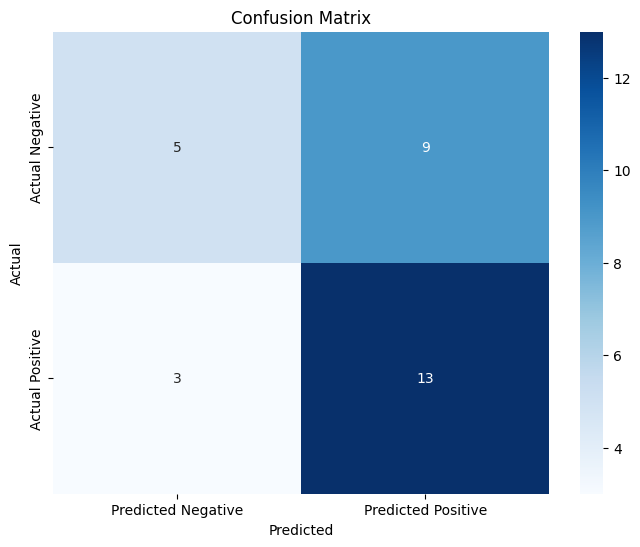

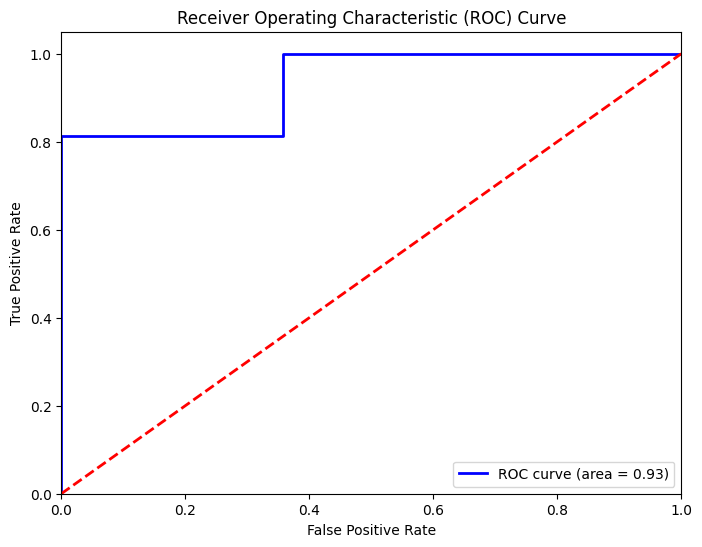

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix_and_roc(TP, TN, FP, FN):
    cm = np.array([[TN, FP],
                   [FN, TP]])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    y_true = [1] * TP + [0] * TN + [1] * FN + [0] * FP  
    y_scores = [0.9] * TP + [0.7] * TN + [0.4] * FN + [0.3] * FP

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_confusion_matrix_and_roc(TP, TN, FP, FN)

It seems that the model have been biased toward the positive class .

<h4>Logistic Regression</h4>